# 权重衰减: weight_decay


## 1、范数与权重衰减
L1范数是指向量中各个元素绝对值之和；

L2范数是指向量各元素的平方和然后求平方根；

L1范数可以进行特征选择，即让特征的系数变为0.

L2范数可以防止过拟合，提升模型的泛化能力，有助于处理 condition number不好下的矩阵(数据变化很小矩阵求解后结果变化很大)

（核心：L2对大数，对outlier离群点更敏感！）

训练参数化机器学习模型时，权重衰减（通常称为 L2 正则化）是最广泛使用的正则化的技术之一。

problems:为什么我们使用平方范数而不是标准范数（即欧几里得距离）？

: 平方L2范数：通过平方 L2 范数，我们去掉平方根，留下权重向量每个分量的平方和。这使得惩罚的导数很容易计算：导数的和等于和的导数。

problems: 为什么我们首先使用 L2 范数，而不是 L1 范数?

: L2 正则化线性模型构成经典的岭回归（ridge regression）算法， L1 正则化线性回归是统计学中类似的基本模型，通常被称为套索回归（lasso regression）。
:L2 范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为鲁棒。相比之下， L1 惩罚会导致模型将其他权重清除为零而将权重集中在一小部分特征上。这称为**特征选择（feature selection）.**

problems: 为什么叫权重衰减？
    
： 我们根据估计值与观测值之间的差异来更新 w 。然而，我们同时也在试图将 w 的大小缩小到零。这就是为什么这种方法有时被称为权重衰减。

## 2、examples: 高维线性回归

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
import sys
sys.path.append('../../CommonFunctions/tools/')
import common_tools

为了使过拟合的效果更加明显，我们可以将问题的维数增加到 d=200 ，并使用一个只包含20个样本的小训练集.

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = common_tools.synthetic_data(true_w, true_b, n_train)
train_iter = common_tools.load_array(train_data, batch_size)
test_data = common_tools.synthetic_data(true_w, true_b, n_test)
test_iter = common_tools.load_array(test_data, batch_size, is_train=False)

从头开始实现权重衰减，只需将 L2 的平方惩罚添加到原始目标函数中。

### 初始化模型参数

In [4]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2范数惩罚
所有项求平方后并将它们求和

In [5]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 定义训练代码

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: common_tools.linreg(X, w, b), common_tools.squared_loss
    num_epochs, lr = 100, 0.003
    animator = common_tools.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            common_tools.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (common_tools.evaluate_loss(net, train_iter, loss),
                                     common_tools.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练

用lambd = 0禁用权重衰减后运行这个代码。 注意，这里训练误差有了减少，但测试误差没有减少。这意味着出现了严重的过拟合。

w的L2范数是： 12.007655143737793


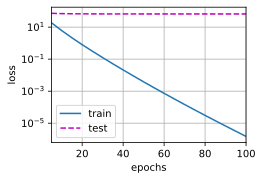

In [7]:
train(lambd=0)

### 使用权重衰减

w的L2范数是： 0.37062835693359375


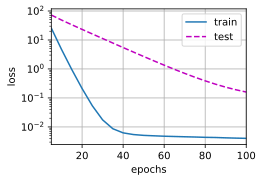

In [8]:
train(lambd=3)

## 简洁实现

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = common_tools.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (common_tools.evaluate_loss(net, train_iter, loss),
                                     common_tools.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.780482292175293


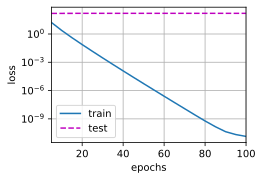

In [10]:
train_concise(0)

w的L2范数： 0.4584418535232544


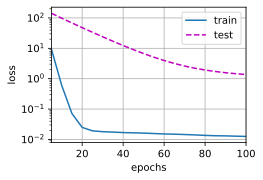

In [11]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。